# Load FlinkMagic extension 

In [17]:
%reload_ext flinkmagic

# Initialize StreamEnvironment 

In [18]:
%flink_init_stream_env

# Define Sink and Source using SQL 

In [19]:
%%flink_execute_sql
CREATE TABLE MySinkDbTable (
    word varchar,
    cnt bigint) WITH (
        'connector.type' = 'jdbc',
        'connector.url' = 'jdbc:mysql://mysql:3306/as42594n',
        'connector.table' = 'word_count',
        'connector.driver' = 'com.mysql.jdbc.Driver',
        'connector.write.flush.interval' = '10',
        'connector.username' = 'root',
        'connector.password' = 'my-secret-pw')

In [20]:
%%flink_execute_sql
CREATE TABLE MySinkDbSmsTable (
    smstext varchar,
    smstype varchar) WITH (
        'connector.type' = 'jdbc',
        'connector.url' = 'jdbc:mysql://mysql:3306/as42594n',
        'connector.table' = 'as42594n',
        'connector.driver' = 'com.mysql.jdbc.Driver',
        'connector.write.flush.interval' = '10',
        'connector.username' = 'root',
        'connector.password' = 'my-secret-pw')

In [21]:
%%flink_execute_sql
CREATE TABLE MySinkPrintSmsTable (
    smstext varchar,
    smstype varchar) WITH (
        'connector' = 'print')

In [22]:
%%flink_execute_sql
CREATE TABLE MySourceKafkaTable (word varchar) WITH (
    'connector.type' = 'kafka',
    'connector.version' = 'universal',
    'connector.topic' = 'as42594n',
    'connector.startup-mode' = 'latest-offset',
    'connector.properties.bootstrap.servers' = 'kafka:9092',
    'connector.properties.group.id' = 'kafka',
    'format.type' = 'csv'
        )

# Load MLflow model 

Here we autoamtically load mlflow model:
```
%flink_mlflow function_name mlflow_model_path input_types result_type
```
where:
* function_name - function name which will be used in SQL eg. SPAM_CLASSIFIER
* mlflow_model_path - path to the mlflow model eg. /mlflow/mlruns/2/64a89b0a6b7346498316bfae4c298535/artifacts/model
* input_types - list of input types in function eg. ```[DataTypes.STRING(),DataTypes.STRING()]``` (avoid spaces :)) full list of types https://ci.apache.org/projects/flink/flink-docs-stable/dev/table/types.html
* result_type - result type eg. ```DataTypes.STRING()``` full list of types https://ci.apache.org/projects/flink/flink-docs-stable/dev/table/types.html

In [23]:
%flink_mlflow "SPAM_CLASSIFIER" "/opt/flink/notebooks/flink-with-ai/data/mlflow/mlruns/2/64a89b0a6b7346498316bfae4c298535/artifacts/model" "[DataTypes.STRING()]" "DataTypes.STRING()"

Function SPAM_CLASSIFIER registered


# Load MLflow using custom UDF python class 

In [24]:
from pyflink.table.expressions import call 
from pyflink.table.udf import ScalarFunction, udf

class SpamClassifier(ScalarFunction):
    def __init__(self, model_id):
        import mlflow.pyfunc
        self.model = mlflow.pyfunc.load_model(f"/opt/flink/notebooks/flink-with-ai/data/mlflow/mlruns/2/{model_id}/artifacts/model")

    def eval(self, s):
        res=self.model.predict([s])
        return res[0]
        #return s

spam_classifier = udf(SpamClassifier("64a89b0a6b7346498316bfae4c298535"), input_types=[DataTypes.STRING()], result_type=DataTypes.STRING())

use ```%flink_register_function``` to register udf:
```
%flink_register_function function_name udf_object
```
where:
* function_name - function name which will be used in SQL eg. SPAM_CLASSIFIER
* udf_object - created udf object eg. spam_classifier

In [25]:
%flink_register_function SPAM_CLASSIFIER spam_classifier

Function SPAM_CLASSIFIER registered


# Flink SQL query which prints the output to  notebook interactively

## Print as a pandas DataFrame 

In [26]:
%%flink_sql_query
SELECT word as smstext, SPAM_CLASSIFIER(word) as smstype FROM MySourceKafkaTable

,smstext,smstype
0,I love working from home :),ham
1,URGENT! You have won a 1 week FREE membership !,spam
2,I will come tomorrow di,ham
3,URGENT! You have won a 1 week FREE membership !,spam
4,URGENT! You have won a 1 week FREE membership !,spam
...,...,...
156,URGENT! You have won a 1 week FREE membership !,spam
157,I will come tomorrow di,ham
158,For ur chance to win a 250 wkly shopping spree...,spam
159,I love working from home :),ham


KeyboardInterrupt: 

## Print as a pie chart 

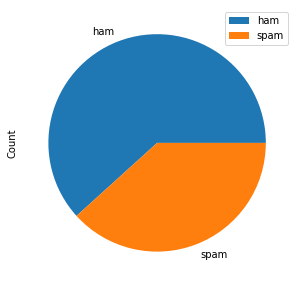

In [ ]:
%%flink_sql_query_pie
SELECT word as smstext, SPAM_CLASSIFIER(word) as smstype FROM MySourceKafkaTable